# Install

In [1]:
!pip install polars_ml

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 45.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.5/31.5 MB 35.2 MB/s eta 0:00:00
  Attempting uninstall: polars
    Found existing installation: polars 0.20.2
    Uninstalling polars-0.20.2:
      Successfully uninstalled polars-0.20.2


# Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import polars as pl

# Create Toy Graph

/usr/local/lib/python3.10/dist-packages/networkx/drawing/nx_pylab.py:450: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


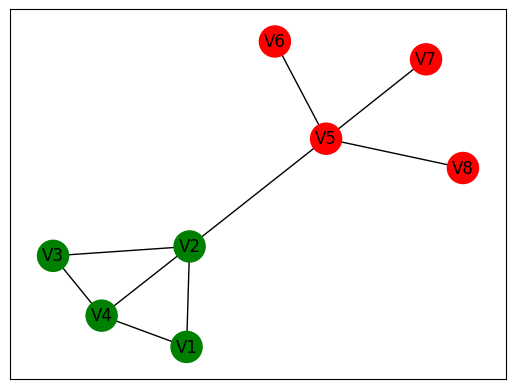

In [3]:
def dataframe_to_networkx(df, src_col, dst_col):
    G = nx.Graph()
    for index, row in df.iterrows():
        G.add_edge(row[src_col], row[dst_col])
    return G

graph_pd = pd.DataFrame([['V1','V2'], ['V2','V1'], ['V2','V3'], ['V3','V2'],
                         ['V4','V2'],['V2','V4'], ['V4','V3'], ['V3', 'V4'], ['V5','V6'], ['V6','V5'],['V5','V7'],
                         ['V7','V5'], ['V2','V5'],['V5','V2'], ['V8','V5'], ['V5', 'V8'],
                         ['V4', 'V1'], ['V1', 'V4']], columns=['SRC','DST'])

graph = dataframe_to_networkx(graph_pd, src_col='SRC', dst_col='DST')

gt_df = pd.DataFrame([['V5',0], ['V6',0], ['V7',0], ['V1',1], ['V3',1],
                      ['V8',0], ['V2',1], ['V4',1]], columns=['NODE','LABEL'])

# visualize graph
def get_colors(df):
    colors = []
    for node in graph.nodes():
        if node in df['NODE'].tolist():
            if df[df['NODE'] == node]['LABEL'].tolist()[0] == 1:
                colors.append('Green')
            else:
                colors.append('Red')
        else:
            colors.append('Yellow')
    return colors

colors = get_colors(gt_df)
pos = nx.spring_layout(graph)
nx.draw_networkx_nodes(graph, pos, cmap=plt.get_cmap('jet'), node_color = colors, node_size = 500)
nx.draw_networkx_labels(graph, pos)
nx.draw_networkx_edges(graph, pos)
plt.show()

# Run Node2vec

In [12]:
import polars_ml as plm

# convert to polars
graph_df = pl.DataFrame(graph_pd).group_by('SRC').agg('DST')

embedding_df = graph_df.lazy().with_columns(
    plm.graph.node2vec(source_node=pl.col('SRC'),
                       neighbors=pl.col('DST'),
                       is_directed=False,
                       max_neighbors=None,
                       embedding_size=64,
                       model_type='skipgram',
                       random_state=42,
                       verbose=True).alias('embedding')
).select('SRC', 'embedding').collect()

In [13]:
embedding_pd = embedding_df.with_columns(pl.col('embedding').list.to_struct()) \
  .unnest('embedding') \
  .to_pandas().set_index('SRC')

embedding_pd.head()

,field_0,field_1,field_2,field_3,field_4,field_5,field_6,field_7,field_8,field_9,...,field_54,field_55,field_56,field_57,field_58,field_59,field_60,field_61,field_62,field_63
SRC,,,,,,,,,,,,,,,,,,,,,
V7,0.258104,0.654510,0.860547,0.270560,-0.015375,0.002635,-0.843850,-0.001975,0.184662,-0.462948,...,-0.451157,0.228249,0.031847,0.451239,-0.316927,-0.210944,0.018070,-0.825293,0.123494,-0.157004
V4,-0.071905,-0.396017,-0.761960,-0.318460,-0.111220,0.175907,0.763651,0.101336,-0.008327,0.363557,...,-0.020977,-0.098617,0.171373,-0.114546,0.085568,-0.109829,0.098460,0.349212,-0.161017,0.245676
V2,0.572501,-0.258366,-0.338719,-0.146178,0.023534,0.116966,0.380797,-0.200855,0.054516,-0.282022,...,-0.405354,-0.009558,-0.111037,-0.403352,-0.297222,0.321188,-0.625164,0.207565,0.368865,0.077765
V1,0.132757,-0.221424,-0.601765,-0.437908,0.336024,-0.049620,0.481705,-0.374507,0.293662,-0.029353,...,-0.037696,-0.248487,0.108285,-0.353971,0.204292,-0.123595,-0.351477,0.450316,-0.014468,0.260419
V3,0.231523,-0.366667,-0.375826,-0.116799,-0.209306,0.205078,0.465117,0.028634,0.003883,0.247847,...,0.243373,-0.286108,0.066684,-0.451128,0.153189,0.409792,-0.329713,0.696728,-0.002568,-0.206481


# KMEANS Clustering

In [14]:
import numpy as np
import itertools
from sklearn.cluster import KMeans

NUM_CLUSTERS = 2

kmeans = KMeans(n_clusters=NUM_CLUSTERS)
kmeans.fit(embedding_pd)
labels = kmeans.predict(embedding_pd)
embedding_clusters_pd = embedding_pd.copy()
embedding_clusters_pd['cluster'] = labels
clusters_pd = embedding_clusters_pd.reset_index()[['SRC','cluster']]
clusters_pd

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,SRC,cluster
0,V7,1
1,V4,0
2,V2,0
3,V1,0
4,V3,0
5,V8,1
6,V5,1
7,V6,1


# Plot Clusters

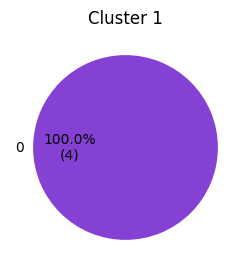

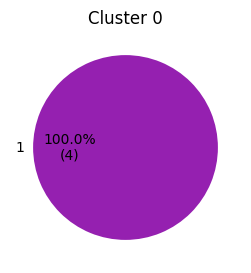

In [15]:
import random


def get_rand_color():
  return "#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])

def plot_clusters(clusters_pd, gt_pd, gt_label_col, cluster_col, id_col):
  clusters_with_labels_pd = pd.merge(gt_pd, clusters_pd, on=id_col, how='inner')
  clusters_grouped_pd = clusters_with_labels_pd.groupby([cluster_col, gt_label_col]).agg({id_col: 'count'}).reset_index()
  all_clusters = clusters_pd[cluster_col].unique().tolist()
  all_labels = gt_pd[gt_label_col].unique().tolist()
  labels_colors = {c: get_rand_color() for c in all_labels}

  for cluster in all_clusters:
      single_cluster_with_labels_pd = clusters_grouped_pd[clusters_grouped_pd[cluster_col] == cluster]
      total = single_cluster_with_labels_pd[id_col].sum()
      def my_fmt(x):
        return '{:.1f}%\n({:.0f})'.format(x, total*x/100)
      fig = plt.figure(figsize=(5, 3))
      plt.pie(single_cluster_with_labels_pd[id_col], labels=single_cluster_with_labels_pd[gt_label_col],
              colors=[labels_colors[l] for l in single_cluster_with_labels_pd[gt_label_col].tolist()],
              autopct=my_fmt)
      plt.title(f'Cluster {cluster}')
      plt.show()

plot_clusters(clusters_pd.rename(columns={'SRC': 'NODE'}), gt_df,
              gt_label_col='LABEL', id_col='NODE', cluster_col='cluster')